# Figure 6B: Plot alignment

We plot the relationship between acceleration and velocity difference, across different alignment conditions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import Batch, Data, DataLoader

In [3]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")
sys.path.append("/workspace/collab-environment/figures")

In [4]:
from collab_env.data.boids.animal_simulation import visualize_graph, visualize_pair
from collab_env.gnn.gnn import (get_adjcency_from_debug, plot_log_loss, train_rules_gnn,
    identify_frames, find_frame_sets, load_model, debug_result2prediction)
from utility import handle_discrete_data
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets

In [5]:
from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.gnn.plotting_utility import load_various_data, load_rollout

In [6]:
from figures.gnn.plot_helpers import (rollout_to_pos_vel_acc,
    data_to_pos_vel_acc,
    figure_data_B,
    mean_trace_B)

## Load Data Config and Rollout result

In [12]:
data_names = ['runpod_old/boid_single_species_basic']
              #'boid_single_species_weak_alignment',
              #'boid_single_species_strong_alignment']#, 'boid_single_species_independent', # without food
              #'boid_food_basic_alignment', 'boid_food_basic_independent', # with food
              #'boid_food_strong'] # with food, strong influence


rollout_results =  {}
data = {}
model_names = ["medium"] #["weak", "medium", "strong"]


for ind in range(len(data_names)):
    spec = {
        "data_name": data_names[ind],
        "head": 1,
        "visual_range": 0.5,
        "seed": 1,
        "rollout_starting_frame": 5,
        "noise": 0
    }
    
    
    rollout_results[model_names[ind]] = load_rollout("vpluspplus_a", **spec)

    data[model_names[ind]] = load_various_data(data_names, 1, return_dict = False)

In [13]:
print("alignment factor")
for model in model_names:
    print(
        data[model]['species_configs']['A']['matching_factor']
    )

alignment factor
0.5


In [18]:
thresholds = np.linspace(0.05, 0.2, 20) 
#the threshold for spatial range, within which we consider boid rule. 0.1 is chosen as this is the boid visual range during simulation

START_FRAME = 5
END_FRAME = 55
plotting_kwargs = {
    "starting_frame": START_FRAME,
    "ending_frame": END_FRAME,
    "version": "singleton"#"boids" #"singleton"
}

[autoreload of collab_env.gnn.gnn failed: Traceback (most recent call last):
  File "/workspace/conda/envs/gnn/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspace/conda/envs/gnn/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
  File "/workspace/conda/envs/gnn/lib/python3.13/importlib/__init__.py", line 129, in reload
    _bootstrap._exec(spec, module)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 1022, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1160, in get_code
  File "<frozen importlib._bootstrap_external>", line 1090, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/workspace/collab-environment/c

### Figure_data_B

In [19]:
# parse alignment
mean_data, bins_data, mean_model, bins_model = {}, {}, {}, {}

for model in model_names:
    print(model)
    
    mean_data[model], bins_data[model] = [], []
    mean_model[model], bins_model[model] = [], []
    
    for t in thresholds:
        plotting_kwargs["threshold"] = t
        plotting_kwargs["model"] = False
        
        """data"""
        test_loader = data[model]["test_loader"]
        del_v, acc = figure_data_B(test_loader, None, **plotting_kwargs)
        bins, mean, sd = mean_trace_B(del_v, acc)
        
        mean_data[model].append(mean)
        bins_data[model].append(bins)
    
    
        """model"""
        plotting_kwargs["model"] = True
        result = rollout_results[model]
        del_v, acc = figure_data_B(None, result, **plotting_kwargs)
        bins, mean, sd = mean_trace_B(del_v, acc)

    
        mean_model[model].append(mean)
        bins_model[model].append(bins)

medium


### Plot

In [20]:
import matplotlib as mpl 
norm = mpl.colors.Normalize(vmin=0, vmax=len(thresholds), clip=True)

medium


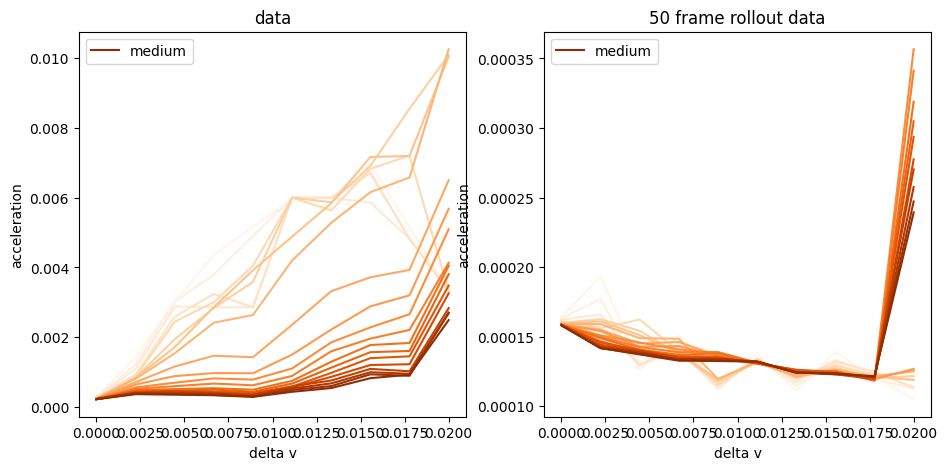

In [21]:
fig, axes = plt.subplots(1,2,figsize=(11, 5))

for model in model_names:
    print(model)
    
    if model == "weak":
        cmap = plt.cm.Greens # Choose a colormap
    elif model == "medium":
        cmap = plt.cm.Oranges # Choose a colormap
    elif model == "strong":
        cmap = plt.cm.Reds # Choose a colormap

    """data"""
    ax = axes[0]
    for t_ind in range(len(thresholds)):

        bins = bins_data[model][t_ind]
        mean = mean_data[model][t_ind]

        if t_ind == len(thresholds)-1:
            label = model
        else:
            label = None
            
        ax.plot(bins, mean, color = cmap(norm(t_ind)), label = label)

    """model"""
    ax2 = axes[1]
    for t_ind in range(len(thresholds)):

        bins = bins_model[model][t_ind]
        mean = mean_model[model][t_ind]

        if t_ind == len(thresholds)-1:
            label = model
        else:
            label = None
            
        ax2.plot(bins, mean, color = cmap(norm(t_ind)), label = label)
    

#ax.fill_between(bins, mean - sd, mean + sd, alpha = 0.5)
#ax.fill_between(bins_weak, mean_weak - sd_weak, mean_weak + sd_weak, alpha = 0.5)
ax.set_title("data")
ax2.set_title(f"{END_FRAME - START_FRAME} frame rollout data")
ax.set_xlabel("delta v")
ax2.set_xlabel("delta v")

ax.set_ylabel("acceleration")
ax2.set_ylabel("acceleration")

ax.legend()
ax2.legend()

plt.show()